✅ Instructions

### 1. Explore the Dataset

* Open the CSV and review its structure
* Refer to: daily_tasks/day_4/day_4_datasets/readme.md


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sqlalchemy import create_engine

In [47]:
df = pd.read_csv('/Users/dianaterraza/Desktop/webeet.io/_onboarding_data/daily_tasks/day_4/day_4_datasets/sat-results.csv')


In [48]:
df.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT Critical Readng Avg. Score,internal_school_id,contact_extension,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,355,218160,x345,78%,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,383,268547,x234,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,377,236446,x123,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,414,427826,x123,92%,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,390,672714,x123,92%,2.0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DBN                              493 non-null    object 
 1   SCHOOL NAME                      493 non-null    object 
 2   Num of SAT Test Takers           493 non-null    object 
 3   SAT Critical Reading Avg. Score  493 non-null    object 
 4   SAT Math Avg. Score              493 non-null    object 
 5   SAT Writing Avg. Score           493 non-null    object 
 6   SAT Critical Readng Avg. Score   493 non-null    object 
 7   internal_school_id               493 non-null    int64  
 8   contact_extension                388 non-null    object 
 9   pct_students_tested              376 non-null    object 
 10  academic_tier_rating             402 non-null    float64
dtypes: float64(1), int64(1), object(9)
memory usage: 42.5+ KB


In [50]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
DBN                                  0
SCHOOL NAME                          0
Num of SAT Test Takers               0
SAT Critical Reading Avg. Score      0
SAT Math Avg. Score                  0
SAT Writing Avg. Score               0
SAT Critical Readng Avg. Score       0
internal_school_id                   0
contact_extension                  105
pct_students_tested                117
academic_tier_rating                91
dtype: int64


* ### Identify which columns are useful and which are synthetic or dirty

Mostly missing

If most rows are empty (NaN, None, or just empty strings), the column:

* Adds no value to the analysis

* Makes the data look messy

* Could cause problems during data uploads (especially to SQL)

In [51]:
# 0. Drop unwanted column right away
df.drop(columns=["contact_extension"], inplace=True)

In [52]:
# 1. Drop the duplicate column with the typo one column says "SAT Critical Reading Avg. Score" and the other "SAT Critical Readng Avg. Score"
df.drop(columns=["SAT Critical Readng Avg. Score"], inplace=True)

### 2. Clean the Data Using Python

* Handle duplicates, invalid SAT scores, and inconsistent formatting (e.g., "85%"), weird outliers and any inconsistencies
* Normalize headers and drop unrelated fields

In [53]:
# 2. Convert numeric columns that were mistakenly read as objects
numeric_columns = [
    "Num of SAT Test Takers",
    "SAT Critical Reading Avg. Score",
    "SAT Math Avg. Score",
    "SAT Writing Avg. Score"
]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")  # invalid values become NaN

In [54]:
# 3. Clean and convert percentage column (remove %, handle 'N/A')
df["pct_students_tested"] = (
    df["pct_students_tested"]
    .str.replace("%", "", regex=False)
    .replace("N/A", np.nan)
    .astype(float)
)

In [55]:
# 4. Optional: Standardize column names (lowercase and underscores)
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [56]:
# 5. Preview cleaned DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dbn                              493 non-null    object 
 1   school_name                      493 non-null    object 
 2   num_of_sat_test_takers           435 non-null    float64
 3   sat_critical_reading_avg._score  435 non-null    float64
 4   sat_math_avg._score              435 non-null    float64
 5   sat_writing_avg._score           435 non-null    float64
 6   internal_school_id               493 non-null    int64  
 7   pct_students_tested              376 non-null    float64
 8   academic_tier_rating             402 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 34.8+ KB


Do we need internal_school_id column? we already have a dbn column?

To confirm it's safe to drop, check if DBN and internal_school_id map 1:1:

In [57]:
# Check uniqueness
print(df[['dbn', 'internal_school_id']].drop_duplicates().shape[0] == df.shape[0])


False


Check inconsistences:

The result is false this suggests inconsistency or data quality issues.

It could be due to:

* Typos

* Duplicated rows with minor differences

* Mismatched or outdated identifiers



In [58]:
# Count how many internal IDs per DBN
df.groupby('dbn')['internal_school_id'].nunique().sort_values(ascending=False).head()

# Or vice versa
df.groupby('internal_school_id')['dbn'].nunique().sort_values(ascending=False).head()


internal_school_id
101855    1
713236    1
724775    1
723932    1
723511    1
Name: dbn, dtype: int64

In [59]:
# Show DBNs linked to multiple internal IDs
df[df.duplicated(subset=['dbn', 'internal_school_id'], keep=False)].sort_values('dbn')
df.head()


,dbn,school_name,num_of_sat_test_takers,sat_critical_reading_avg._score,sat_math_avg._score,sat_writing_avg._score,internal_school_id,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,218160,78.0,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,268547,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,236446,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7.0,414.0,401.0,359.0,427826,92.0,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,672714,92.0,2.0


In this case the column dbn is more reliable than internal_school_id so I proceed to drop it. 

In [60]:
# 0. Drop unwanted column internal_school_id
df.drop(columns=["internal_school_id"], inplace=True)

* ### Outliers

SAT Critical Reading Avg. Score  | Average score achieved in the Critical Reading section (valid: 200–800)

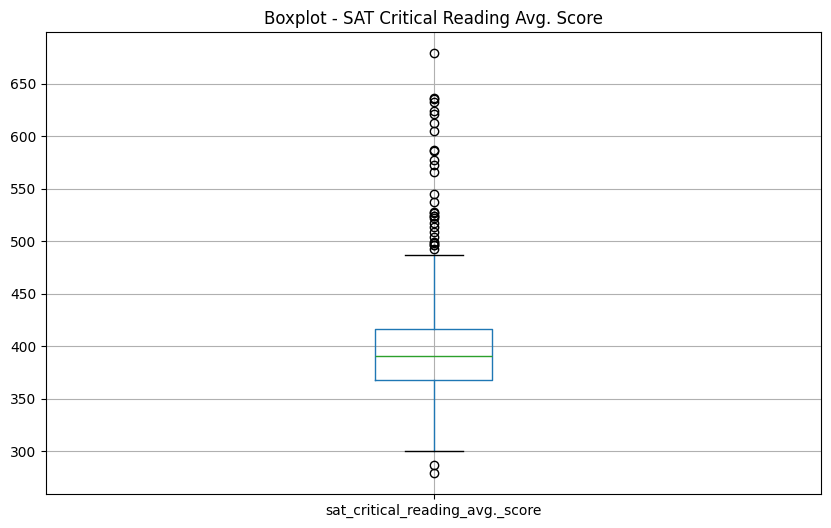

In [61]:
# boxplots for identifying outliers in column sat_critical_reading_avg._score
df.boxplot(column='sat_critical_reading_avg._score', figsize=(10, 6))
plt.title("Boxplot - SAT Critical Reading Avg. Score")
plt.show()


 SAT Math Avg. Score              | Average score achieved in the Math section (valid: 200–800)

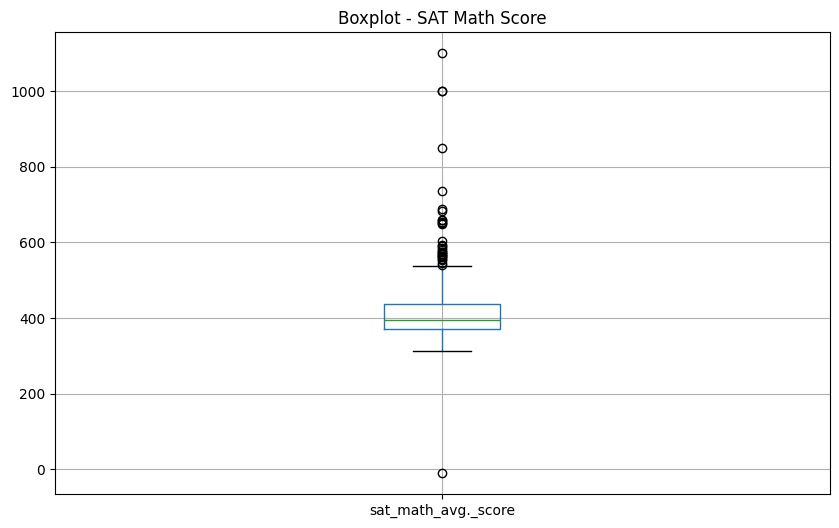

In [62]:
# boxplots for identifying outliers in column sat_math_avg._score
df.boxplot(column='sat_math_avg._score',figsize=(10, 6))
plt.title("Boxplot - SAT Math Score")
plt.show()


As it shows this column sat_math_avg._score has outliers. Since SAT scores should be between 200 and 800 i can convert it in null values: 


In [63]:
# Replace values ​​outside the range [200, 800] with NaN
df.loc[(df['sat_math_avg._score'] < 200) | (df['sat_math_avg._score'] > 800), 'sat_math_avg._score'] = np.nan
df.loc

Plot again to prove:

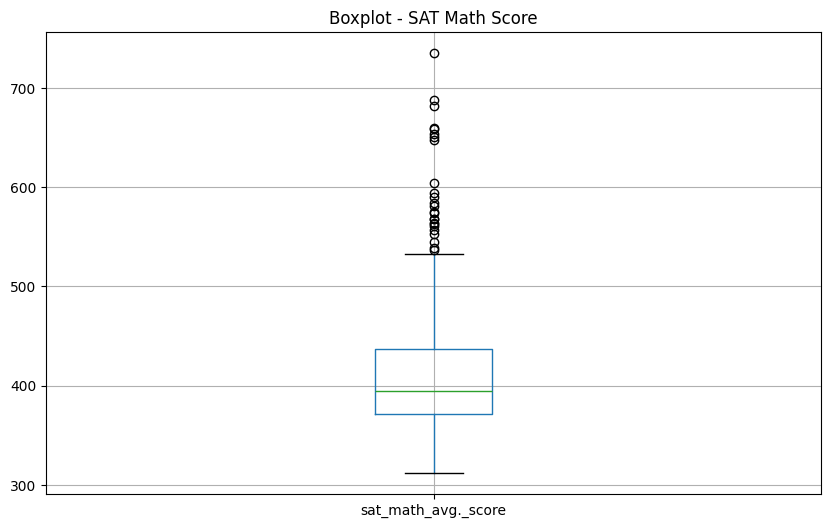

In [64]:
# boxplots for identifying outliers in column sat_math_avg._score
df.boxplot(column='sat_math_avg._score',figsize=(10, 6))
plt.title("Boxplot - SAT Math Score")
plt.show()

SAT Writing Avg. Score           | Average score achieved in the Writing section (valid: 200–800)

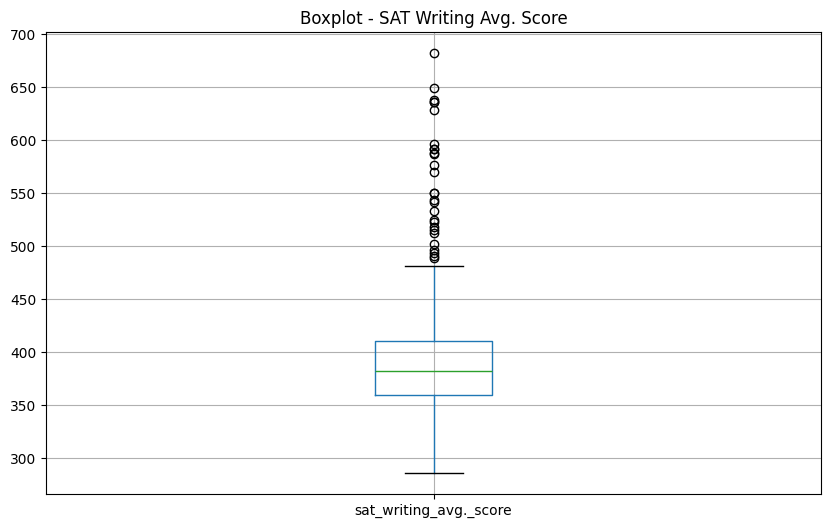

In [65]:
# boxplots for identifying outliers in column sat_writing_avg._score
df.boxplot(column='sat_writing_avg._score',figsize=(10, 6))
plt.title("Boxplot - SAT Writing Avg. Score")
plt.show()


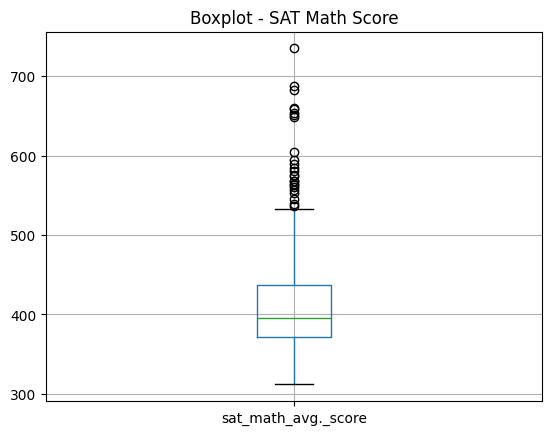

In [66]:
# boxplots for identifying outliers in column sat_math_avg._score
df.boxplot(column='sat_math_avg._score')
plt.title("Boxplot - SAT Math Score")
plt.show()

* ### Duplicates

1. Check for duplicates in the entire dataset:

In [67]:
df.duplicated().any()

np.True_

2. Count total duplicate rows

In [68]:
df.duplicated().sum()


np.int64(15)

3. View duplicate rows

In [69]:
df[df.duplicated()]


,dbn,school_name,num_of_sat_test_takers,sat_critical_reading_avg._score,sat_math_avg._score,sat_writing_avg._score,pct_students_tested,academic_tier_rating
478,14K685,EL PUENTE ACADEMY FOR PEACE AND JUSTICE,28.0,359.0,335.0,341.0,92.0,4.0
479,13K605,GEORGE WESTINGHOUSE CAREER AND TECHNICAL EDUCA...,85.0,406.0,391.0,392.0,NaN,NaN
480,27Q480,JOHN ADAMS HIGH SCHOOL,403.0,391.0,409.0,392.0,92.0,1.0
481,07X221,SOUTH BRONX PREPARATORY: A COLLEGE BOARD SCHOOL,65.0,364.0,378.0,348.0,92.0,NaN
482,19K420,FRANKLIN K. LANE HIGH SCHOOL,NaN,NaN,NaN,NaN,78.0,3.0
483,09X525,BRONX LEADERSHIP ACADEMY HIGH SCHOOL,114.0,384.0,394.0,388.0,92.0,1.0
484,02M520,MURRY BERGTRAUM HIGH SCHOOL FOR BUSINESS CAREERS,264.0,407.0,440.0,393.0,92.0,2.0
485,17K543,"SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...",69.0,457.0,462.0,441.0,85.0,NaN
486,02M419,LANDMARK HIGH SCHOOL,62.0,390.0,399.0,381.0,78.0,2.0
487,05M304,MOTT HALL HIGH SCHOOL,54.0,413.0,399.0,398.0,78.0,2.0


4. Finally Remove duplicates

In [70]:
df = df.drop_duplicates()


 ### 3. Design the Schema

Choose columns to upload to the database

| Column Name                      | SQL Name                 | Type      | Description                         |
| -------------------------------- | ------------------------ | --------- | ----------------------------------- |
| `dbn`                            | `dbn`                    | `TEXT`    | Unique school code                  |
| `school_name`                    | `school_name`            | `TEXT`    | Full name of the high school        |
| `num_of_sat_test_takers`         | `num_of_sat_test_takers` | `INTEGER` | Number of students who took the SAT |
| `sat_critical_reading_avg_score` | `reading_score`          | `INTEGER` | Avg. score in Critical Reading      |
| `sat_math_avg_score`             | `math_score`             | `INTEGER` | Avg. score in Math                  |
| `sat_writing_avg_score`          | `writing_score`          | `INTEGER` | Avg. score in Writing               |
| `pct_students_tested`            | `pct_students_tested`    | `FLOAT`   | % of students tested (0–100)        |
| `academic_tier_rating`           | `academic_tier_rating`   | `FLOAT`   | Tier rating (1–4)                   |

* Select the relevant Columns

In [71]:
columns_to_upload = [
    "dbn",
    "school_name",
    "num_of_sat_test_takers",
    "sat_critical_reading_avg._score",
    "sat_math_avg._score",
    "sat_writing_avg._score",
    "pct_students_tested",
    "academic_tier_rating"
]

df_to_upload = df[columns_to_upload]


* Rename Columns to match the DB schema

In [72]:
df_to_upload.rename(columns={
    "num_of_sat_test_takers": "test_takers",
    "sat_critical_reading_avg_score": "reading_score",
    "sat_math_avg_score": "math_score",
    "sat_writing_avg_score": "writing_score"
}, inplace=True)


In [75]:
df_to_upload

,dbn,school_name,test_takers,sat_critical_reading_avg._score,sat_math_avg._score,sat_writing_avg._score,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,78.0,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7.0,414.0,401.0,359.0,92.0,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,92.0,2.0
...,...,...,...,...,...,...,...,...
473,75X012,P.S. X012 LEWIS AND CLARK SCHOOL,NaN,NaN,NaN,NaN,92.0,1.0
474,75X754,J. M. RAPPORT SCHOOL CAREER DEVELOPMENT,NaN,NaN,NaN,NaN,NaN,4.0
475,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,NaN,NaN,NaN,NaN,85.0,1.0
476,79Q950,GED PLUS s CITYWIDE,8.0,496.0,400.0,426.0,92.0,2.0


* Define the SQL Schema

### 4. Write a Python Script to Append Data

* Use psycopg2 or sqlalchemy to connect
* Append cleaned data to your sat_scores table
* Use parameterized queries and commit logic

In [77]:
db_url = (
    "postgresql+psycopg2://neondb_owner:npg_CeS9fJg2azZD"
    "@ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech:5432/neondb"
    "?sslmode=require"
)

engine = create_engine(db_url)

df_to_upload.to_sql(
    name='diana_sat_results',   
    con=engine,
    schema='nyc_schools',              
    if_exists='replace',               
    index=False
)

478